In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -q "/content/drive/MyDrive/Dissertation/Desertation_train_3model/дисертация_за_месяц/train.zip" -d "/content/data"


replace /content/data/train/0/10_right.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import yaml
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import StratifiedKFold
from torchvision import models, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler

In [4]:
torch.backends.cudnn.benchmark = True

In [14]:
# Загрузка настроек
with open('/content/drive/MyDrive/Dissertation/Desertation_train_3model/дисертация_за_месяц/parametrs.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# Установка сидов
seed = config['experiment']['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


# Загружаем модель и параметры
device = torch.device(config['training']['device'] if torch.cuda.is_available() else "cpu")
num_epochs = config['training']['num_epochs']
batch_size = 64
early_stopping_patience = config['training']['patience']
learning_rate = 0.00001
weight_decay = config['training'].get('weight_decay', 0.0)


root_dir = '/content/data/train'

In [15]:
# Путь к данным
train_csv = config['dataset']['train_csv']
df = pd.read_csv(train_csv)

In [16]:
df['true_label'] = df['true_label'].astype(int)
print("Распределение классов:")
print(df['true_label'].value_counts())

Распределение классов:
true_label
0    18867
1     6260
2     6260
Name: count, dtype: int64


In [17]:
from torchvision import transforms
from PIL import Image
import os



def get_transform_pipeline(config, label=None):
    transform_list = []

    transform_config = config.get('train_transforms', {})
    common_transforms = transform_config.get('common', [])
    transform_list.extend(parse_transforms(common_transforms, config))

    # Классы 1 и 2 получают сильные аугментации
    if label in [1, 2]:
        label_key = str(label)
        class_specific = transform_config.get(label_key, [])
        transform_list.extend(parse_transforms(class_specific, config))

    transform_list.extend([
        transforms.ToTensor(),
        transforms.Normalize(mean=config['dataset']['mean'], std=config['dataset']['std'])
    ])

    return transforms.Compose(transform_list)

def parse_transforms(transform_names, config):
    transform_ops = []
    # image_size = config['dataset']['image_size']
    transform_ops.append(transforms.Resize((380, 380)))

    for name in transform_names:
        if name == "horizontal_flip":
            transform_ops.append(transforms.RandomHorizontalFlip())
        elif name == "vertical_flip":
            transform_ops.append(transforms.RandomVerticalFlip())
        elif name == "color_jitter":
            transform_ops.append(transforms.ColorJitter(0.3, 0.3, 0.2, 0.1))
        elif name == "random_affine":
            transform_ops.append(transforms.RandomAffine(15, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=5))
        elif name == "gaussian_blur":
            transform_ops.append(transforms.GaussianBlur(kernel_size=3))
        elif name == "random_erasing":
            transform_ops.append(transforms.RandomErasing(p=0.2))
        else:
            raise ValueError(f"Неизвестная трансформация: {name}")

    return transform_ops



In [18]:
# Feature Extractor для ViT
class FundusDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, config):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.config = config

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['image_name']
        label = int(row['true_label'])
        img_path = os.path.join(self.root_dir, str(label), img_name)
        image = Image.open(img_path).convert("RGB")

        transform = get_transform_pipeline(self.config, label=label)
        image = transform(image)

        # Возвращаем изображение, метку и имя файла
        return image, label, img_name


In [19]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
import torch.nn.functional as F

class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # может быть тензором с весами классов
        self.reduction = reduction

    def forward(self, inputs, targets):
        logpt = F.log_softmax(inputs, dim=1)
        pt = torch.exp(logpt)
        logpt = logpt.gather(1, targets.unsqueeze(1)).squeeze(1)
        pt = pt.gather(1, targets.unsqueeze(1)).squeeze(1)

        if self.alpha is not None:
            at = self.alpha.gather(0, targets)
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss


In [21]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, config, fold=0, criterion=None):
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score,
        f1_score, confusion_matrix, cohen_kappa_score, roc_auc_score
    )
    from sklearn.preprocessing import label_binarize
    from torch.cuda.amp import GradScaler, autocast
    import os

    early_stopping_patience = config['training'].get('early_stopping_patience', 3)
    model_save_path = config['training'].get('model_save_path', 'checkpoints/')
    num_epochs = config['training'].get('num_epochs', 20)
    freeze_epochs = config['training'].get('freeze_encoder_epochs', 3)

    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    patience_counter = 0

    scaler = GradScaler()

    # Замораживаем энкодер
    if freeze_epochs > 0:
        for name, param in model.named_parameters():
            if "classifier" not in name:
                param.requires_grad = False

    for epoch in range(num_epochs):
        # Размораживаем после freeze_epochs
        if epoch == freeze_epochs:
            for param in model.parameters():
                param.requires_grad = True

        model.train()
        running_train_loss = 0.0

        for inputs, labels, _ in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_train_loss += loss.item()

        scheduler.step()
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        all_labels, all_preds, all_probs, image_names = [], [], [], []
        hard_examples = []

        with torch.no_grad():
            for inputs, labels, filenames in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with autocast():
                    outputs = model(inputs)
                    logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                    loss = criterion(logits, labels)

                running_val_loss += loss.item()

                probs = torch.softmax(logits, dim=1)
                preds = torch.argmax(probs, dim=1)
                sample_losses = nn.functional.cross_entropy(logits, labels, reduction='none')

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                image_names.extend(filenames)

                for i in range(len(labels)):
                    if preds[i] != labels[i] or sample_losses[i].item() > 1.0:
                        hard_examples.append({
                            'image_name': filenames[i],
                            'true_label': labels[i].item(),
                            'pred_label': preds[i].item(),
                            'loss': sample_losses[i].item()
                        })

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            save_path = os.path.join(model_save_path, f"baseline_effi_fold{fold + 1}.pth")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            torch.save(model.state_dict(), save_path)
        elif epoch > 0 and avg_val_loss > best_val_loss and avg_train_loss < train_losses[-2]:
            patience_counter += 1
            print(f"Validation loss ↑ while train loss ↓. Patience {patience_counter}/{early_stopping_patience}")
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered due to overfitting.")
                break

    # Final metrics
    num_classes = len(set(all_labels))
    print("\nFinal Metrics on Validation Set:")
    print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Recall: {recall_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Cohen's Kappa: {cohen_kappa_score(all_labels, all_preds):.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(all_labels, all_preds)}")

    try:
        y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
        auc = roc_auc_score(y_true_bin, all_probs, multi_class='ovr', average='macro')
        print(f"AUC-ROC (OvR, macro): {auc:.4f}")
    except Exception as e:
        print(f"AUC-ROC calculation failed: {e}")

    plot_training_history(train_losses, val_losses)
    return all_labels, all_preds, all_probs, image_names



====== Fold 1 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-21-ffb0ad378fa6>:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-21-ffb0ad378fa6>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-21-ffb0ad378fa6>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/50 | Train Loss: 1.4381 | Val Loss: 1.3956
Epoch 2/50 | Train Loss: 1.3627 | Val Loss: 1.3235
Epoch 3/50 | Train Loss: 1.2968 | Val Loss: 1.2599
Epoch 4/50 | Train Loss: 1.0182 | Val Loss: 0.6845
Epoch 5/50 | Train Loss: 0.5890 | Val Loss: 0.4651
Epoch 6/50 | Train Loss: 0.4927 | Val Loss: 0.4275
Epoch 7/50 | Train Loss: 0.4548 | Val Loss: 0.4059
Epoch 8/50 | Train Loss: 0.4292 | Val Loss: 0.3930
Epoch 9/50 | Train Loss: 0.4170 | Val Loss: 0.3835
Epoch 10/50 | Train Loss: 0.4032 | Val Loss: 0.3770
Epoch 11/50 | Train Loss: 0.3926 | Val Loss: 0.3707
Epoch 12/50 | Train Loss: 0.3799 | Val Loss: 0.3669
Epoch 13/50 | Train Loss: 0.3712 | Val Loss: 0.3620
Epoch 14/50 | Train Loss: 0.3613 | Val Loss: 0.3577
Epoch 15/50 | Train Loss: 0.3578 | Val Loss: 0.3558
Epoch 16/50 | Train Loss: 0.3458 | Val Loss: 0.3524
Epoch 17/50 | Train Loss: 0.3400 | Val Loss: 0.3502
Epoch 18/50 | Train Loss: 0.3352 | Val Loss: 0.3494
Epoch 19/50 | Train Loss: 0.3333 | Val Loss: 0.3468
Epoch 20/50 | Train L

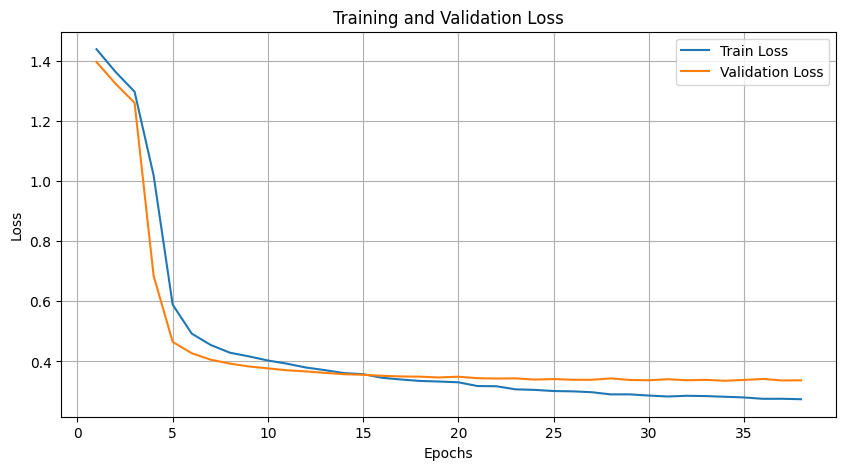


====== Fold 2 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-21-ffb0ad378fa6>:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-21-ffb0ad378fa6>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-21-ffb0ad378fa6>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/50 | Train Loss: 1.4141 | Val Loss: 1.3731
Epoch 2/50 | Train Loss: 1.3428 | Val Loss: 1.3033
Epoch 3/50 | Train Loss: 1.2813 | Val Loss: 1.2448
Epoch 4/50 | Train Loss: 0.9878 | Val Loss: 0.6698
Epoch 5/50 | Train Loss: 0.5720 | Val Loss: 0.4722
Epoch 6/50 | Train Loss: 0.4766 | Val Loss: 0.4360
Epoch 7/50 | Train Loss: 0.4494 | Val Loss: 0.4188
Epoch 8/50 | Train Loss: 0.4318 | Val Loss: 0.4025
Epoch 9/50 | Train Loss: 0.4144 | Val Loss: 0.3925
Epoch 10/50 | Train Loss: 0.4033 | Val Loss: 0.3904
Epoch 11/50 | Train Loss: 0.3885 | Val Loss: 0.3801
Epoch 12/50 | Train Loss: 0.3795 | Val Loss: 0.3745
Epoch 13/50 | Train Loss: 0.3697 | Val Loss: 0.3730
Epoch 14/50 | Train Loss: 0.3631 | Val Loss: 0.3643
Epoch 15/50 | Train Loss: 0.3550 | Val Loss: 0.3615
Epoch 16/50 | Train Loss: 0.3497 | Val Loss: 0.3607
Epoch 17/50 | Train Loss: 0.3412 | Val Loss: 0.3531
Epoch 18/50 | Train Loss: 0.3368 | Val Loss: 0.3531
Validation loss ↑ while train loss ↓. Patience 1/3
Epoch 19/50 | Train Lo

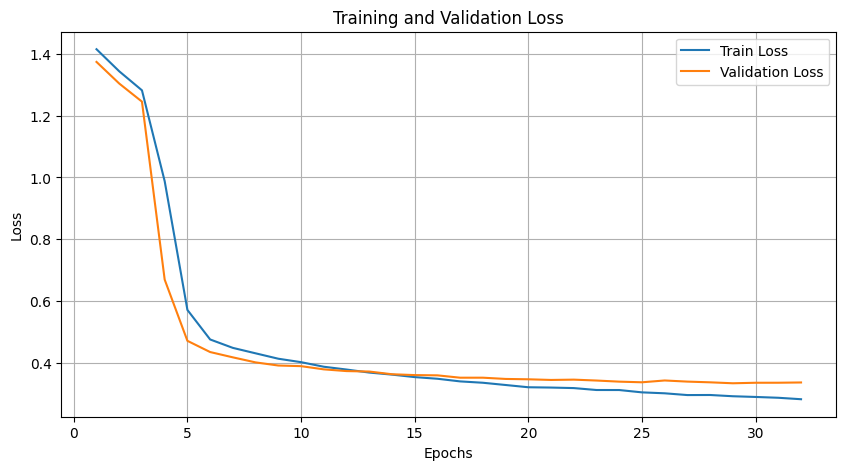


====== Fold 3 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-21-ffb0ad378fa6>:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-21-ffb0ad378fa6>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-21-ffb0ad378fa6>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/50 | Train Loss: 1.4329 | Val Loss: 1.3913
Epoch 2/50 | Train Loss: 1.3587 | Val Loss: 1.3181
Epoch 3/50 | Train Loss: 1.2934 | Val Loss: 1.2544
Epoch 4/50 | Train Loss: 1.0121 | Val Loss: 0.6901
Epoch 5/50 | Train Loss: 0.5887 | Val Loss: 0.4665
Epoch 6/50 | Train Loss: 0.4815 | Val Loss: 0.4224
Epoch 7/50 | Train Loss: 0.4524 | Val Loss: 0.4075
Epoch 8/50 | Train Loss: 0.4332 | Val Loss: 0.3954
Epoch 9/50 | Train Loss: 0.4130 | Val Loss: 0.3847
Epoch 10/50 | Train Loss: 0.4016 | Val Loss: 0.3815
Epoch 11/50 | Train Loss: 0.3942 | Val Loss: 0.3728
Epoch 12/50 | Train Loss: 0.3837 | Val Loss: 0.3734
Validation loss ↑ while train loss ↓. Patience 1/3
Epoch 13/50 | Train Loss: 0.3730 | Val Loss: 0.3635
Epoch 14/50 | Train Loss: 0.3634 | Val Loss: 0.3598
Epoch 15/50 | Train Loss: 0.3520 | Val Loss: 0.3569
Epoch 16/50 | Train Loss: 0.3532 | Val Loss: 0.3537
Epoch 17/50 | Train Loss: 0.3457 | Val Loss: 0.3510
Epoch 18/50 | Train Loss: 0.3341 | Val Loss: 0.3477
Epoch 19/50 | Train Lo

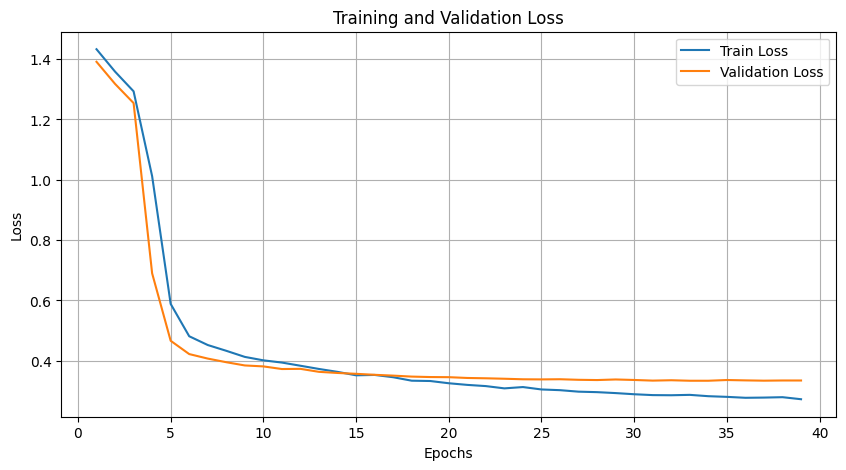


Все фолды завершены. Результаты сохранены в 'kfold_efficientnetb4_predictions.csv'


In [22]:
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
import torch.optim as optim

# === KFold и обучение ===
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
all_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['true_label'])):
    print(f"\n====== Fold {fold + 1} ======")

    # Подготовка данных
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

    # Датасеты и DataLoader'ы
    train_dataset = FundusDataset(train_df, root_dir=root_dir, config=config)
    val_dataset = FundusDataset(val_df, root_dir=root_dir, config=config)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=15, pin_memory=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=15, pin_memory=False)

    # --- Модель EfficientNet-B4 ---
    model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
    model.to(device)

    # --- Оптимизатор ---
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # --- Scheduler ---
    scheduler_type = config['training'].get('scheduler', 'cosine').lower()
    if scheduler_type == 'cosine':
        scheduler = CosineAnnealingLR(optimizer, T_max=config['training']['num_epochs'])
    elif scheduler_type == 'step':
        scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    else:
        raise ValueError(f"Unknown scheduler: {scheduler_type}")

    # --- FocalLoss с весами ---
    class_counts = train_df['true_label'].value_counts().sort_index().values
    total_samples = class_counts.sum()
    class_weights = [total_samples / c for c in class_counts]
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    focal_loss_fn = FocalLoss(gamma=2.0, alpha=class_weights_tensor)

    # --- Сохранение пути модели ---
    config['training']['model_save_path'] = f"best_model_fold{fold + 1}.pth"

    # --- Обучение ---
    labels, preds, probs, image_names = train_model(
        model, train_loader, val_loader, optimizer, scheduler, device, config,
        fold=fold, criterion=focal_loss_fn
    )

    # --- Сохранение результатов ---
    fold_df = pd.DataFrame({
        'image_name': image_names,
        'true_label': labels,
        'pred_label': preds,
        'fold': fold + 1
    })
    all_results.append(fold_df)

# --- Финальный CSV ---
final_df = pd.concat(all_results, ignore_index=True)
final_df.to_csv("kfold_efficientnetb4_predictions.csv", index=False)
print("\nВсе фолды завершены. Результаты сохранены в 'kfold_efficientnetb4_predictions.csv'")
